# AL glomeruli meshes
In this notebook we will demonstrate the generation of meshes from synapse point clouds.

In [12]:
import navis

import numpy as np
import pandas as pd
import seaborn as sns
import trimesh as tm
import multiprocessing as mp
import matplotlib.pyplot as plt
import navis.interfaces.neuprint as neu

from tqdm.auto import tqdm
from scipy import ndimage, stats
from skimage import measure
from itertools import product

client = neu.Client('https://neuprint.janelia.org', dataset='hemibrain:v1.2')

First, we need to generate Gaussian KDEs for each glomerulus

In [2]:
# Fetch the AL mesh
al = neu.fetch_roi('AL(R)')

In [3]:
# Get a list of RNs
rns = pd.read_csv('https://github.com/flyconnectome/hemibrain_olf_data/raw/master/FIB_RNs.csv')

# Skip those without glomerulus 
rns = rns[~rns.glomerulus.isnull()]

# Drop the "VM6" (i.e. those that could not be assigned to a subpopulation)
rns = rns[rns.glomerulus != 'VM6']

rns.head()

,Unnamed: 0,bodyid,name,type,glomerulus,soma_side,modality,cable.length.glom.um,presyn,presyn.glom,notes
0,67,1605204239,ORN_D,ORN_D,D,NaN,olfactory,NaN,NaN,NaN,NaN
1,90,5812993853,ORN_D,ORN_D,D,NaN,olfactory,NaN,NaN,NaN,NaN
2,89,1703359176,ORN_D,ORN_D,D,NaN,olfactory,NaN,NaN,NaN,NaN
3,88,1701343239,ORN_D,ORN_D,D,NaN,olfactory,NaN,NaN,NaN,NaN
4,87,1671970762,ORN_D,ORN_D,D,NaN,olfactory,NaN,NaN,NaN,NaN


In [6]:
# Fetch all the synapses
syn = neu.fetch_synapses(neu.SegmentCriteria(bodyId=rns.bodyid.values))
syn = syn[syn.roi == 'AL(R)']
syn.head()

  0%|          | 0/264 [00:00<?, ?it/s]

,bodyId,type,roi,x,y,z,confidence
0,1793696526,pre,AL(R),17192,32259,26782,0.991
1,1793696526,pre,AL(R),17126,32324,26735,0.994
2,1793696526,pre,AL(R),15756,31846,25752,0.975
3,1793696526,pre,AL(R),15803,31849,25748,0.961
4,1793696526,pre,AL(R),16615,31421,28147,0.974


Let's see how many synapses we have per glomerulus

In [7]:
numbers = []
for g in rns.glomerulus.unique():
    this_rns = rns[rns.glomerulus == g]
    this_syn = syn[syn.bodyId.isin(this_rns.bodyid.values)]
    
    numbers.append([g, len(this_rns),
                    this_syn[this_syn.type == 'pre'].shape[0],
                    this_syn[this_syn.type == 'post'].shape[0]])
syn_numbers = pd.DataFrame(numbers, columns=['glomerulus', 'n_rns', 'n_pre', 'n_post']).sort_values(['n_rns', 'n_pre'])
syn_numbers.head()

,glomerulus,n_rns,n_pre,n_post
43,VM2,1,19,29
56,VP2,3,1259,1601
57,VP3,4,2333,2258
54,VP1l,6,1493,2400
55,VP1m,6,1849,3032


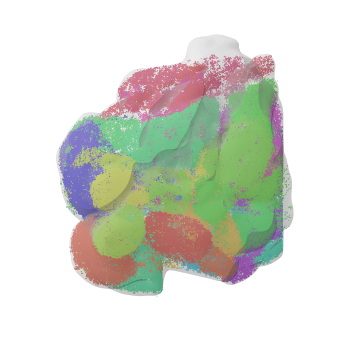

In [10]:
# A quick plot
fig, ax = navis.plot2d([al], method='3d')

gloms = rns.glomerulus.unique()
cols = sns.color_palette('hls', len(gloms))
for i,g in enumerate(gloms):
    to_plot = syn[syn.bodyId.isin(rns[rns.glomerulus == g].bodyid.values)]
    navis.plot2d(to_plot[['x','y','z']].values, ax=ax,
                 method='3d', scatter_kws=dict(color=cols[i]))

# Top view
ax.elev = ax.azim = -90

Now generate the KDEs 

In [13]:
glom_kde = {}
is_pre = syn['type'] == 'pre'
for g in tqdm(rns.glomerulus.unique()):
    # Skip VM2 -> too few RNs/synapses
    if g == 'VM2':
        continue
    
    locs = syn.loc[is_pre & (syn.bodyId.isin(rns[rns.glomerulus == g].bodyid.values)), ['x', 'y', 'z']].values
    glom_kde[g] = stats.gaussian_kde(locs.T)
    
gloms = list(glom_kde.keys())
print(f'KDEs for {len(gloms)} generated.')

  0%|          | 0/60 [00:00<?, ?it/s]

KDEs for 59 generated.


Next: tile the AL into isotropic voxels

In [14]:
# Voxel size in pixel (1px = 8nm)
res = 60 # = 480nm
padding = 250
xco = np.arange(al.bbox[0][0] - padding, al.bbox[1][0] + padding, res)
yco = np.arange(al.bbox[0][1] - padding, al.bbox[1][1] + padding, res)
zco = np.arange(al.bbox[0][2] - padding, al.bbox[1][2] + padding, res)

i = np.arange(0, xco.shape[0], 1)
j = np.arange(0, yco.shape[0], 1)
k = np.arange(0, zco.shape[0], 1)

ii, jj, kk = np.meshgrid(i, j, k)
xx, yy, zz = np.meshgrid(xco, yco, zco)

In [15]:
# Turn the voxel coordinates into a DataFrame
voxels = np.vstack((xx.flatten(), yy.flatten(), zz.flatten())).T
voxels = pd.DataFrame(voxels, columns=['x', 'y', 'z'])

# This is the index of each voxel
voxels['i'] = ii.flatten()
voxels['j'] = jj.flatten()
voxels['k'] = kk.flatten()

voxels.head()

,x,y,z,i,j,k
0,13302.017578,25340.625,22298.712891,0,0,0
1,13302.017578,25340.625,22358.712891,0,0,1
2,13302.017578,25340.625,22418.712891,0,0,2
3,13302.017578,25340.625,22478.712891,0,0,3
4,13302.017578,25340.625,22538.712891,0,0,4


In [16]:
print(f'AL tiled into {voxels.shape[0]} isotropic voxels')

AL tiled into 8870400 isotropic voxels


Next up: for each glomerulus calculate the PDF over all voxels.

In [ ]:
def _worker_wrapper(x):
    """Helper class to run this on multiple_cores"""
    f, args, kwargs = x
    return f(*args, **kwargs)

# Prepare combination to be distributed across cores
combinations = []
for g in list(glom_kde):
    combinations.append([glom_kde[g], [voxels[['x','y','z']].values.T], {}])

# Run the actual porcessing
with mp.Pool(n_cores=5) as pool:        
    results = list(tqdm(pool.imap(_worker_wrapper,
                              combinations,
                              chunksize=1),
                        total=len(combinations),
                        desc='Calc.'))

# Add the results to the Dataframe
for g, r in zip(glom_kde, results):
    voxels[g] = r

In [15]:
voxels.head()

,x,y,z,i,j,k,D,DA1,DA2,DA3,...,VM6v,VM7d,VM7v,VP1d,VP1l,VP1m,VP2,VP3,VP4,VP5
0,13302.017578,25340.625,22298.712891,0,0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.120007e-208,0.0,0.0,0.0,3.978351e-285,0.0,0.000000e+00
1,13302.017578,25340.625,22358.712891,0,0,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.431222e-207,0.0,0.0,0.0,1.604275e-282,0.0,0.000000e+00
2,13302.017578,25340.625,22418.712891,0,0,2,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.022927e-205,0.0,0.0,0.0,6.187743e-280,0.0,0.000000e+00
3,13302.017578,25340.625,22478.712891,0,0,3,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.967736e-204,0.0,0.0,0.0,2.282701e-277,0.0,0.000000e+00
4,13302.017578,25340.625,22538.712891,0,0,4,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,8.379325e-203,0.0,0.0,0.0,8.054117e-275,0.0,1.976263e-323


We empirically determined a good threshold to determine whether a voxel is inside any glomerulus: `1e-11`

In [23]:
# Assign a glomerulus to each voxel based on the max probability
voxels['glom'] = np.array(gloms)[np.argmax(voxels[gloms].values, axis=1)]

In [35]:
# Remove voxels that are outside of any glomerulus and outside the AL
vxl_in = voxels.loc[(voxels[gloms].max(axis=1) >= 1e-11) & voxels.in_al].copy()

In [68]:
vxl_in.head()

,x,y,z,i,j,k,D,DA1,DA2,DA3,...,VM7v,VP1d,VP1l,VP1m,VP2,VP3,VP4,VP5,in_al,glom
703722,20864.550781,26300.605469,32019.431641,126,16,162,0.0,0.0,0.0,0.0,...,1.742576e-217,1.308040e-18,5.997934e-74,9.994886e-17,1.213822e-11,6.805587e-22,1.956557e-170,1.839614e-15,True,VP2
703941,20924.550781,26300.605469,31959.431641,127,16,161,0.0,0.0,0.0,0.0,...,6.582122e-215,1.891088e-18,2.082268e-74,2.984522e-17,1.293292e-11,1.649685e-22,1.449189e-167,7.716253e-16,True,VP2
704159,20984.550781,26300.605469,31839.431641,128,16,159,0.0,0.0,0.0,0.0,...,6.273629e-213,2.484133e-18,1.691703e-73,5.780665e-18,1.204552e-11,6.071207e-23,1.190003e-160,4.825397e-16,True,VP2
704160,20984.550781,26300.605469,31899.431641,128,16,160,0.0,0.0,0.0,0.0,...,1.423389e-212,2.602190e-18,6.962155e-75,7.465658e-18,1.319247e-11,4.148620e-23,1.003101e-164,3.462586e-16,True,VP2
705903,21464.550781,26300.605469,30879.431641,136,16,143,0.0,0.0,0.0,0.0,...,7.650873e-218,2.173846e-17,1.321056e-67,6.459012e-28,1.229225e-11,2.050726e-27,2.281523e-111,3.808183e-17,True,VP2


Now we generate the actual meshes

In [ ]:
# Iterate over all glomerulus
for g in tqdm(gloms):
    # This the voxels for this glomerulus
    this_glom = vxl_in[vxl_in.glom == g] 
    
    # Generate empty matrix
    mat = np.zeros((voxels.i.max() + 1, voxels.j.max() + 1, voxels.k.max() + 1))
    
    # Fill matrix
    mat[this_glom.i, this_glom.j, this_glom.k] = 1
    
    # Remove binary holes
    mat = ndimage.binary_fill_holes(mat)    
    
    # We need one round of erodes to make meshes non-overlapping
    mat = ndimage.binary_erosion(mat)

    # Run the marching cubes algorithm
    verts, faces, normals, values = measure.marching_cubes_lewiner(mat.astype(float), 
                                                                   level=0,
                                                                   allow_degenerate=False, step_size=1)
    # Turn from voxel indices back into nm
    verts *= res
    
    # Add offsets
    offset = voxels[['x', 'y', 'z']].min(axis=0)
    verts += offset
    verts += 0.5 * res
    
    # Turn into a trimesh
    new_mesh = tm.Trimesh(vertices=verts, faces=faces, normals=normals)
    
    # Drop small stuff (anything that makes up less than 10% of the faces)
    cc = tm.graph.connected_components(edges=new_mesh.face_adjacency,
                                       nodes=np.arange(len(new_mesh.faces)),
                                       min_len=1,
                                       engine=None)
    if len(cc) > 1:
        keep = np.concatenate([c for c in cc if len(c) >= 20])
        n_faces = new_mesh.faces.shape[0]
        new_mesh = new_mesh.submesh([np.concatenate([c for c in cc if ((len(c) / n_faces) >= 0.1)])])[0]
        
    # Fix normals 
    new_mesh.fix_normals()    
    
    # Save to obj file
    new_mesh.export(f'{g}.stl')    